In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt

In [2]:
# https://transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time#
    
cols_to_keep = [ "FlightDate",
"Reporting_Airline",
"Flight_Number_Reporting_Airline", "OriginAirportID", "Origin",
"OriginCityName", "OriginState", 
"OriginWac", "DestAirportID", "Dest", "DestCityName", "DestState",
"CRSDepTime", "DepTime",
"DepDelay", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn", "CRSArrTime",
"ArrTime", "ArrDelay", "Cancelled", "CancellationCode", "Diverted",
"CRSElapsedTime", "ActualElapsedTime", "AirTime", "Flights", "Distance",
"CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay",
"LateAircraftDelay", ]

In [3]:
def fetch_cache(url,fname):
    if os.path.exists(fname):
        return pd.read_pickle(fname)
    else:
        df = pd.read_csv(url)
        df.to_pickle(fname)
        return df
    
lookup_Reporting_Airline = fetch_cache("https://transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS","df_carriers.pkl")
lookup_AirportID = fetch_cache("https://transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT_ID", "df_airports.pkl")

In [4]:
def object_to_categorical(df):
    for c in df.columns:
        if str(df[c].dtype) != "object": continue
        if "Date" in c: continue
        print("Making {} categorical".format(c))
        df[c] = df[c].astype("category")
    return df
        

In [5]:
def modify_df(df):
    df["Reporting_AirlineName"] = df["Reporting_Airline"].map(lookup_Reporting_Airline.set_index("Code")["Description"])
    df["FlightDate"] = pd.to_datetime(df["FlightDate"])
    df = object_to_categorical(df)
    return df

In [6]:
os.system("mkdir -p data/")
def download(year,month):
    pklname = "data/flights_{}_{}.pkl.bz2".format(year,month)
    if os.path.exists(pklname): return
    print("Going to make {}".format(pklname))
    zipname = "On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{}_{}.zip".format(year,month)
    cmd = "curl -C - -O https://transtats.bts.gov/PREZIP/{}".format(zipname)
    print("Running: {}".format(cmd))
    os.system(cmd)
    cmd = "unzip {}".format(zipname)
    print("Running: {}".format(cmd))
    os.system(cmd)
    csvname = glob.glob("On_Time_Reporting*_{}_{}.csv".format(year,month))[0]
    df = pd.read_csv(csvname,usecols=cols_to_keep)
    df = modify_df(df)
    print("Saving pickle {}".format(pklname))
    df.to_pickle(pklname)
    cmd = "rm \"{}\"".format(zipname)
    print("Running: {}".format(cmd))
    os.system(cmd)
    cmd = "rm \"{}\"".format(csvname)
    print("Running: {}".format(cmd))
    os.system(cmd)
    

In [7]:
for year in range(2010,2020)[::-1]:
    for month in range(1,13)[::-1]:
        if month > 2 and year == 2019: continue
        download(year,month)

In [8]:
def slim_df(df):
    df = df.drop([
        "DestAirportID",
        "DestState",
        "Diverted",
        "Flights",
        "OriginAirportID",
        "OriginState",
        "OriginWac",
        "WheelsOff",
        "WheelsOn",
    ],axis=1)
    df = object_to_categorical(df)
    ks = ["CRSElapsedTime","CRSDepTime","DepTime","DepDelay","TaxiOut","TaxiIn","CRSArrTime","ArrTime","ArrDelay",
         "ActualElapsedTime","AirTime","Distance","CarrierDelay","WeatherDelay","NASDelay","SecurityDelay",
         "LateAircraftDelay","Flight_Number_Reporting_Airline"]
    df[ks] = df[ks].fillna(0).clip(lower=-32000,upper=32000).astype("int16")
    df["Cancelled"] = df["Cancelled"].astype("bool")
    df = df.reset_index(drop=True)
    return df

In [9]:
%%time
os.system("mkdir -p slimdata/")
for year in range(2010,2020)[::-1]:
    outname = "slimdata/flights_{}.pkl.bz2".format(year)
    if os.path.exists(outname): continue
    print year
    fnames = glob.glob("data/flights_{}_*.pkl.bz2".format(year))
    dfs = [pd.read_pickle(fname) for fname in tqdm_notebook(fnames)]
    df = pd.concat(dfs)
    df = slim_df(df)
    df.to_pickle(outname)
    del df

CPU times: user 586 µs, sys: 1.48 ms, total: 2.06 ms
Wall time: 10.2 ms


In [2]:
# http://lasp.colorado.edu/lisird/data/american_relative_sunspot_number_daily/
dfsun = pd.read_csv("./american_relative_sunspot_number_daily.csv")
dfsun.columns = ["time","ra"]
dfsun["time"] = pd.to_datetime(dfsun["time"])
dfsun = dfsun.set_index("time")

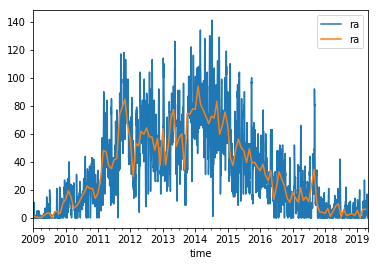

In [3]:
ax = dfsun.plot()
dfsun.resample("1M").mean().plot(ax=ax)

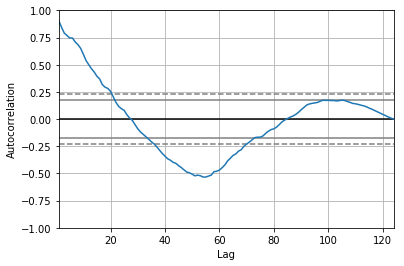

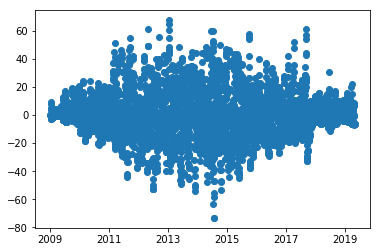

In [13]:
# period of ~105months?
pd.plotting.autocorrelation_plot(dfsun["ra"].resample("1m").median())
dfsun["dra"] = dfsun["ra"]-dfsun.rolling("30d").mean()["ra"]
# dfsun["dra"].plot()
fig,ax = plt.subplots()
ax.plot_date(dfsun.index,dfsun["dra"])
# dfsun
# ax = pd.plotting.autocorrelation_plot(dfsun["dra"])
# ax.set_xlim([0.,50])

,ra,dra
time,,
2009-01-02,0.0,0.000000
2009-01-03,0.0,0.000000
2009-01-04,0.0,0.000000
2009-01-05,0.0,0.000000
2009-01-06,0.0,0.000000
2009-01-07,1.0,0.833333
2009-01-08,0.0,-0.142857
2009-01-09,6.0,5.125000
2009-01-10,11.0,9.000000


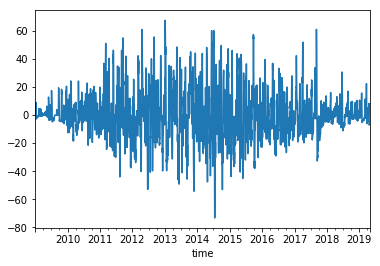

In [154]:
dfsun["dra"].plot()
dfsun


In [64]:
%%time
df = pd.concat([
    pd.read_pickle("slimdata/flights_2010.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2011.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2012.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2013.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2014.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2015.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2016.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2017.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2018.pkl.bz2"),
    pd.read_pickle("slimdata/flights_2019.pkl.bz2"),
])
df = object_to_categorical(df)
df.reset_index(drop=True,inplace=True)

Making Reporting_Airline categorical
Making Origin categorical
Making OriginCityName categorical
Making Dest categorical
Making DestCityName categorical
Making Reporting_AirlineName categorical
CPU times: user 1min 49s, sys: 13.1 s, total: 2min 2s
Wall time: 2min 3s


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56263417 entries, 0 to 56263416
Data columns (total 27 columns):
FlightDate                         datetime64[ns]
Reporting_Airline                  category
Flight_Number_Reporting_Airline    int16
Origin                             category
OriginCityName                     category
Dest                               category
DestCityName                       category
CRSDepTime                         int16
DepTime                            int16
DepDelay                           int16
TaxiOut                            int16
TaxiIn                             int16
CRSArrTime                         int16
ArrTime                            int16
ArrDelay                           int16
Cancelled                          bool
CancellationCode                   category
CRSElapsedTime                     int16
ActualElapsedTime                  int16
AirTime                            int16
Distance                           int1

In [69]:
# df.groupby("Reporting_AirlineName")["ArrDelay"].mean().sort_values(ascending=False)
# df.groupby("Reporting_AirlineName")["DepDelay"].mean().sort_values(ascending=False)

In [94]:
american = df[df.Reporting_Airline=="AA"].set_index("FlightDate").resample("1y")["DepDelay"].mean()
southwest = df[df.Reporting_Airline=="WN"].set_index("FlightDate").resample("1y")["DepDelay"].mean()
skywest = df[df.Reporting_Airline=="OO"].set_index("FlightDate").resample("1y")["DepDelay"].mean()
delta = df[df.Reporting_Airline=="DL"].set_index("FlightDate").resample("1y")["DepDelay"].mean()
united = df[df.Reporting_Airline=="UA"].set_index("FlightDate").resample("1y")["DepDelay"].mean()
jetblue = df[df.Reporting_Airline=="B6"].set_index("FlightDate").resample("1y")["DepDelay"].mean()

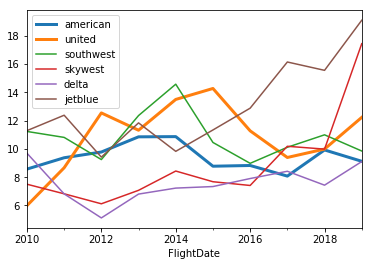

In [177]:
american.plot(label="american",lw=3)
united.plot(label="united",lw=3)
southwest.plot(label="southwest")
skywest.plot(label="skywest")
delta.plot(label="delta")
jetblue.plot(label="jetblue")
ax = plt.gca()
ax.legend()

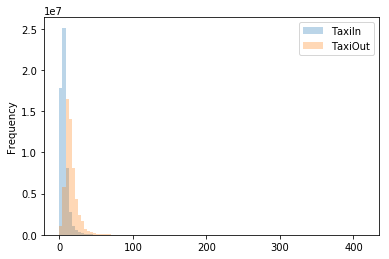

In [76]:
df[[
    "TaxiIn","TaxiOut",
#     "CRSDepTime","DepTime","CRSArrTime",
#     "ArrTime","CRSElapsedTime","ActualElapsedTime",
#     "AirTime"
]].plot.hist(bins=100,alpha=0.3)

Cancelled
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: DepDelay, dtype: object

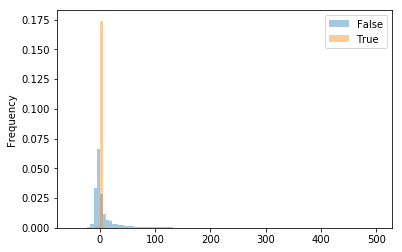

In [82]:
df.groupby(df.Cancelled)["DepDelay"].plot.hist(bins=np.linspace(-50,500,100),stacked=False,alpha=0.4,density=True,legend=True)

In [84]:
# df.groupby("Reporting_AirlineName")["Cancelled"].mean().sort_values(ascending=False)
(df.groupby("Reporting_AirlineName")["DepDelay"]>30).sum().sort_values(ascending=False)

AttributeError: 'bool' object has no attribute 'sum'

In [91]:
df.groupby("Reporting_AirlineName")["DepDelay"].apply(lambda x: (x>30).mean()).sort_values(ascending=False)

Reporting_AirlineName
JetBlue Airways                0.149840
ExpressJet Airlines LLC        0.138993
Spirit Air Lines               0.136458
Allegiant Air                  0.135459
Frontier Airlines Inc.         0.133761
Virgin America                 0.123261
PSA Airlines Inc.              0.122190
United Air Lines Inc.          0.121736
Southwest Airlines Co.         0.116947
ExpressJet Airlines Inc.       0.116398
Envoy Air                      0.114598
American Airlines Inc.         0.111207
SkyWest Airlines Inc.          0.108425
Republic Airline               0.107349
Endeavor Air Inc.              0.106729
Mesa Airlines Inc.             0.097963
Continental Air Lines Inc.     0.090402
Delta Air Lines Inc.           0.082983
AirTran Airways Corporation    0.077502
US Airways Inc.                0.071921
Alaska Airlines Inc.           0.061909
Hawaiian Airlines Inc.         0.027138
Name: DepDelay, dtype: float64

In [155]:
x = df[:10]

In [160]:
df = df.merge(dfsun,how="left",left_on="FlightDate",right_on="time")

In [161]:
df

,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Origin,OriginCityName,Dest,DestCityName,CRSDepTime,DepTime,DepDelay,...,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Reporting_AirlineName,ra,dra
0,2010-06-05,9E,3650,ATL,"Atlanta, GA",TYS,"Knoxville, TN",1726,1728,2,...,27,152,0,0,0,0,0,Endeavor Air Inc.,18.0,10.700000
1,2010-06-01,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,933,22,...,58,341,0,0,0,0,0,Endeavor Air Inc.,10.0,1.533333
2,2010-06-02,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,946,35,...,64,341,0,0,6,0,35,Endeavor Air Inc.,13.0,4.866667
3,2010-06-03,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,943,32,...,59,341,0,0,0,0,17,Endeavor Air Inc.,15.0,7.400000
4,2010-06-06,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,1002,51,...,59,341,0,0,15,0,51,Endeavor Air Inc.,9.0,1.866667
5,2010-06-07,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,909,-2,...,52,341,0,0,0,0,0,Endeavor Air Inc.,5.0,-2.200000
6,2010-06-08,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,910,-1,...,59,341,0,0,0,0,0,Endeavor Air Inc.,11.0,3.433333
7,2010-06-09,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,930,19,...,58,341,0,0,0,0,0,Endeavor Air Inc.,17.0,8.866667
8,2010-06-04,9E,3650,JAN,"Jackson/Vicksburg, MS",ATL,"Atlanta, GA",911,910,-1,...,55,341,0,0,0,0,0,Endeavor Air Inc.,17.0,9.666667
9,2010-06-10,9E,3650,MSP,"Minneapolis, MN",CMH,"Columbus, OH",705,702,-3,...,83,627,0,0,0,0,0,Endeavor Air Inc.,24.0,15.066667


Text(0.5,0,'Departure delay (min.)')

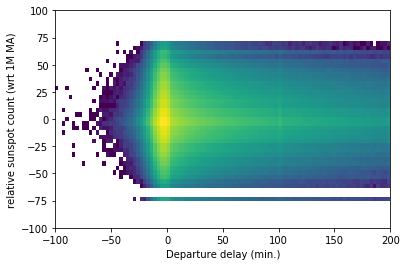

In [179]:
# df.head()[["DepDelay","dra"]]plot()
x = df["DepDelay"]
y = df["dra"]
plt.hist2d(x,y,bins=[np.linspace(-100,200,100),np.linspace(-100,100,50)],norm=LogNorm());
ax = plt.gca()
ax.set_ylabel("relative sunspot count (wrt 1M MA)")
ax.set_xlabel("Departure delay (min.)")

In [171]:
from matplotlib.colors import LogNorm

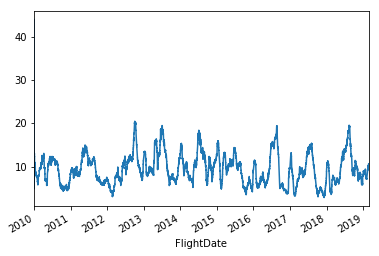

In [182]:
x = df[df.Reporting_Airline=="AA"].set_index("FlightDate").sort_index().rolling("30d")["DepDelay"].mean()
x.plot()

In [191]:
x = df.groupby("OriginCityName")["TaxiOut"].agg(["mean","count"]).sort_values("mean",ascending=False)
x[x["count"]>500]

,mean,count
OriginCityName,,
"New York, NY",25.873347,1967072
"Philadelphia, PA",21.210062,760099
"Newark, NJ",20.940046,1084406
"Ithaca/Cortland, NY",20.592654,4819
"Williston, ND",20.420242,12331
"Sault Ste. Marie, MI",19.640372,3765
"Cape Girardeau, MO",19.356627,830
"Charlotte, NC",19.291357,1254713
"Detroit, MI",19.057894,1162009


In [192]:
x = df.groupby("DestCityName")["TaxiIn"].agg(["mean","count"]).sort_values("mean",ascending=False)
x[x["count"]>500]

,mean,count
DestCityName,,
"Los Angeles, CA",11.019571,1975863
"Dallas/Fort Worth, TX",10.321696,2326459
"Chicago, IL",9.949152,3537421
"Charlotte, NC",9.581116,1254747
"Atlanta, GA",9.296718,3546087
"Newark, NJ",8.884126,1085121
"Pago Pago, TT",8.646154,715
"Miami, FL",8.578127,705054
"New York, NY",8.545412,1966956


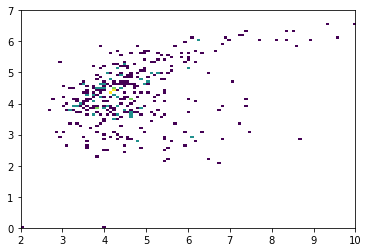

In [203]:
# plt.hist2d(x["mean"].values,x["count"].values,);
plt.hist2d(x["mean"].values,np.log10(x["count"].values),bins=[np.linspace(2,10,100),np.linspace(0,7,100)],norm=LogNorm());

In [216]:
# df["WeatherDelay"].hist(bins=100,log=True)
# (60.*df["Distance"]/df["AirTime"]).plot.hist(np.linspace(0,1000,100))
df["speed"] = 60.*df["Distance"]/df["AirTime"]
# df.resample("1y")

In [219]:
# huge memory issue
# df.set_index("FlightDate").resample("1y")["speed"].median()

KeyboardInterrupt: 